In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tqdm import tqdm_notebook as tqdm
from ipywidgets import IntProgress

import os
import sagemaker

In [8]:
df_35 = pd.read_csv('datasets/CS2_35.csv',index_col=0).dropna()
df_36 = pd.read_csv('datasets/CS2_36.csv',index_col=0).dropna()
df_37 = pd.read_csv('datasets/CS2_37.csv',index_col=0).dropna()
df_38 = pd.read_csv('datasets/CS2_38.csv',index_col=0).dropna()

In [10]:
def ConvertData(dataset,t_width):
    
    X_trains = []
    y_trains = []
    
    for df in dataset:
        t_length = len(df)

        train_x = np.arange(t_length)
        capacity = np.array(df['capacity'])
        train_y = capacity
        
        for i in range(t_length - t_width):
            X_trains.append(train_y[i:i + t_width])
            y_trains.append(train_y[i + t_width])

    X_trains = np.array(X_trains)
    y_trains = np.array(y_trains)
    
    return X_trains,y_trains

In [11]:
X_train,y_train = ConvertData([df_35,df_37,df_38],50)
X_test,y_test = ConvertData([df_36],50)

In [12]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2588, 50) (873, 50) (2588,) (873,)


In [13]:
idx = np.arange(0,X_train.shape[0],1)
idx = np.random.permutation(idx)
idx_lim = idx[:500]

X_train = X_train[idx_lim]
y_train = y_train[idx_lim]

In [14]:
X_train = X_train.reshape([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.reshape([X_test.shape[0], X_test.shape[1], 1])
y_train = y_train.reshape([y_train.shape[0], 1])
y_test = y_test.reshape([y_test.shape[0], 1])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(500, 50, 1) (873, 50, 1) (500, 1) (873, 1)


In [15]:
length_of_sequence = X_train.shape[1]
in_out_neurons = 1
n_hidden = 3

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), 
               return_sequences=False,dropout=0))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [20]:
# !pip install livelossplot

In [19]:
from livelossplot import PlotLossesKeras

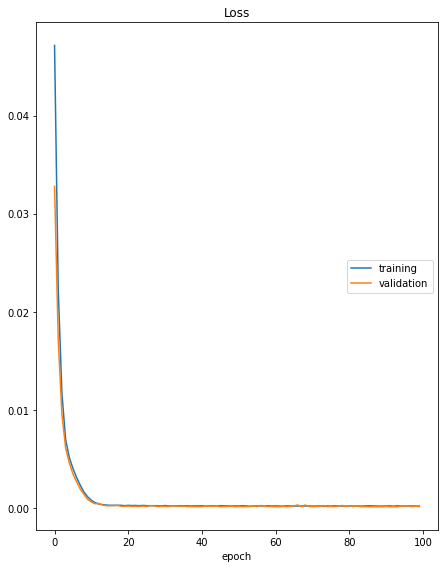

Loss
	training         	 (min:    0.000, max:    0.047, cur:    0.000)
	validation       	 (min:    0.000, max:    0.033, cur:    0.000)
CPU times: user 1min 10s, sys: 10.7 s, total: 1min 20s
Wall time: 1min 24s


In [21]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history = model.fit(X_train, y_train,
          batch_size=50,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping,PlotLossesKeras()]
          )

In [22]:
predicted = model.predict(X_train)
predicted = predicted.reshape(predicted.shape[0])

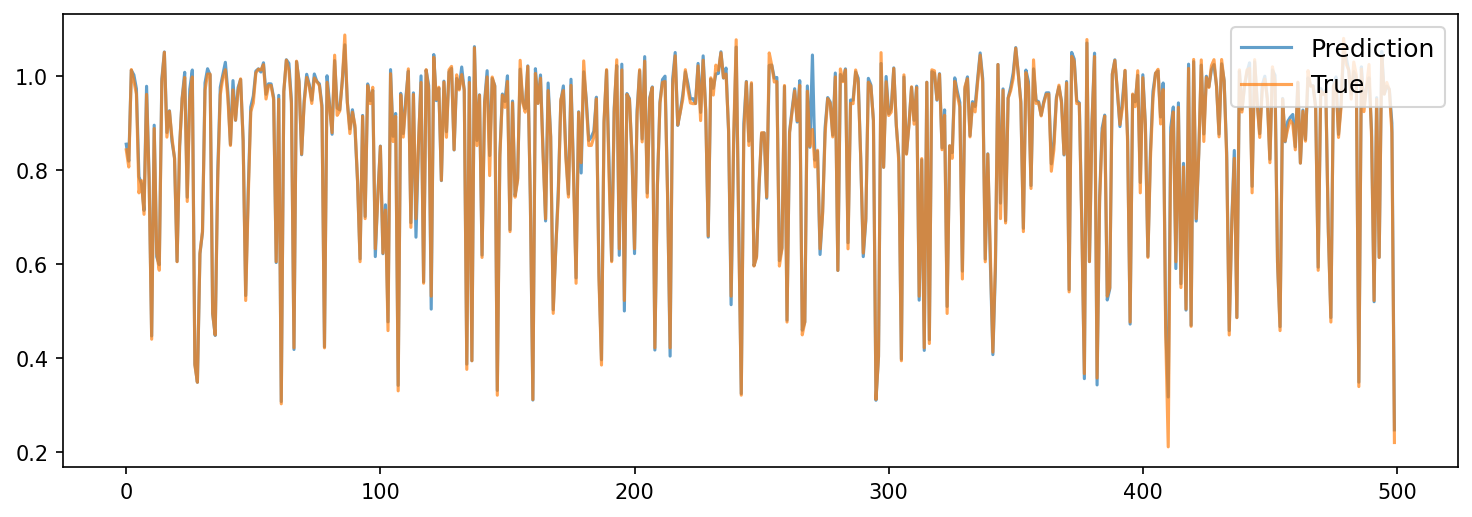

In [23]:
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(predicted,alpha=0.7,label='Prediction')
plt.plot(y_train,alpha=0.7,label='True')
plt.legend(loc='upper right',fontsize=12)

In [24]:
predicted = model.predict(X_test[300:800])
predicted = predicted.reshape(predicted.shape[0])

In [34]:
print(len(predicted))
print(len(y_test[300:800]))

500
500


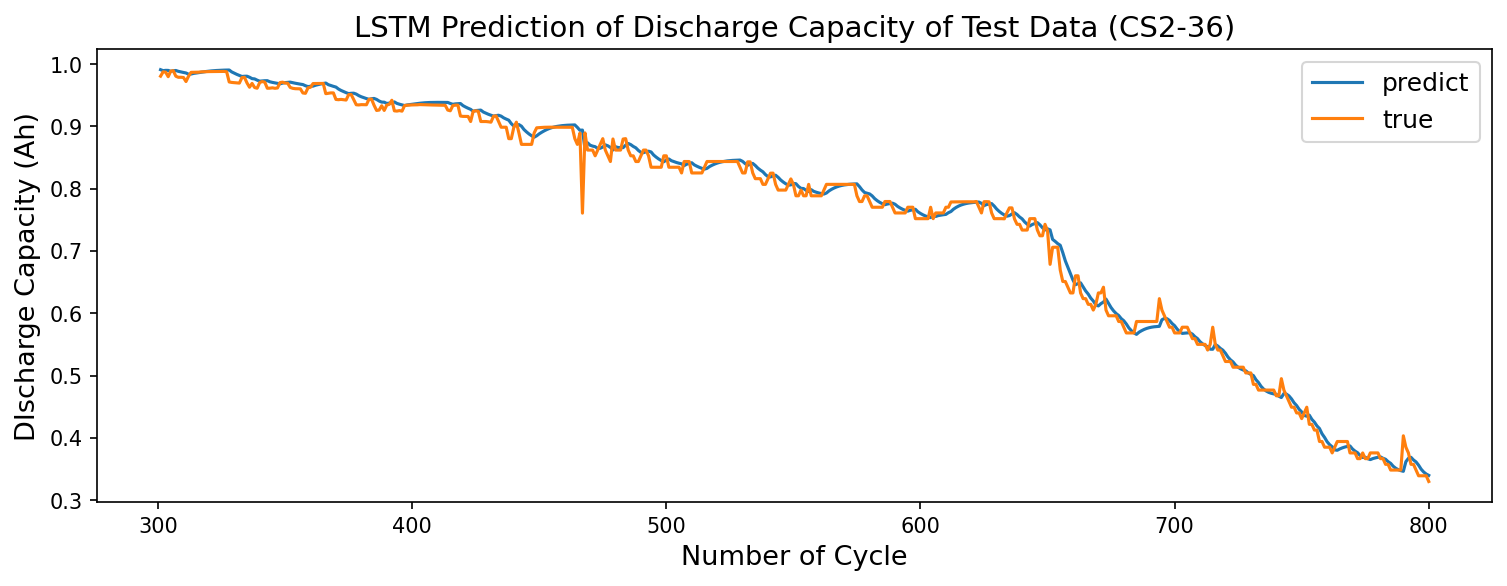

In [27]:
x_range = np.linspace(301,800,500)
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(x_range,predicted,label='predict')
plt.plot(x_range,y_test[300:800],label='true')
plt.xlabel('Number of Cycle',fontsize=13)
plt.ylabel('DIscharge Capacity (Ah)',fontsize=13)
plt.title('LSTM Prediction of Discharge Capacity of Test Data (CS2-36)',fontsize=14)
plt.legend(loc='upper right',fontsize=12)

In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test[300:800], predicted)

0.00017775749299095287

In [31]:
# initial = X_test[500]
# results = []
# for i in tqdm(range(50)):
#     if(i == 0):
#         initial = initial.reshape(1,50,1)
#         res = model.predict(initial)
#         results.append(res[0][0])
#     else:
#         initial = initial.reshape(50,1)
#         initial = np.vstack((initial[1:],np.array(res)))
#         initial = initial.reshape(1,50,1)
#         res = model.predict([initial])
#         results.append(res[0][0])

In [32]:
# fig=plt.figure(figsize=(12,4),dpi=150)
# plt.plot(np.linspace(501,550,50),results,'o-',ms=4,lw=1,label='predict')
# plt.plot(np.linspace(401,550,150),y_test[400:550],'o-',lw=1,ms=4,label='true')
# plt.legend(loc='upper right',fontsize=12)
# plt.xlabel('Number of Cycle',fontsize=13)
# plt.ylabel('Discharge Capacity (Ah)',fontsize=13)